# Naive example of Grover's Algorithm (created with prior knowledge of their solutions)

In [2]:
!pip install qiskit --quiet
!pip install qiskit[visualization] --quiet
!pip install qiskit_aer --quiet

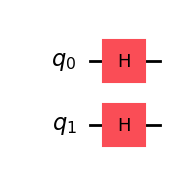

In [25]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere


# Step 1: Create the Grover circuit for 2 qubits
qc = QuantumCircuit(2)

# Step 2: Put both qubits into superposition
qc.h([0, 1])
qc.draw('mpl')


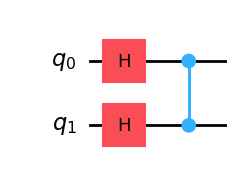

In [26]:
# Step 3: Oracle for |11⟩ → flips the phase of |11⟩ only
# The CZ gate applies a Z gate to qubit 1 if qubit 0 is |1⟩ → flips sign of |11⟩
qc.cz(0, 1)
qc.draw('mpl')

Statevector([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j],
            dims=(2, 2))


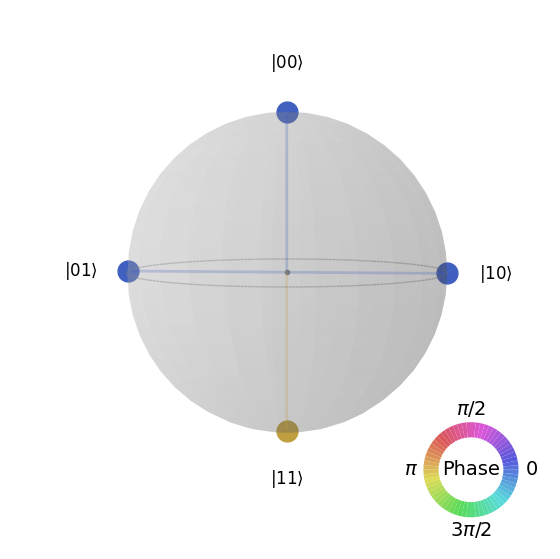

In [27]:
state_oracle = Statevector.from_instruction(qc)
print(state_oracle)
plot_state_qsphere(state_oracle)

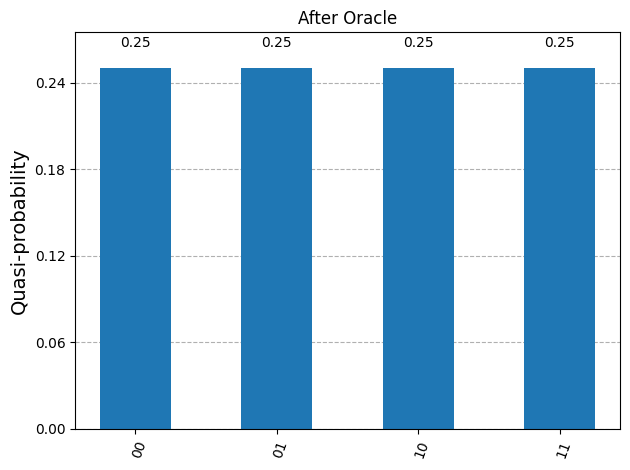

In [28]:
plot_histogram(state_oracle.probabilities_dict(), title="After Oracle")
#The probabilities are unchanged by the oracle
#CZ gate only flips the phase
#It does not change measurement probabilities
#Equal probabilities for all 4 states.

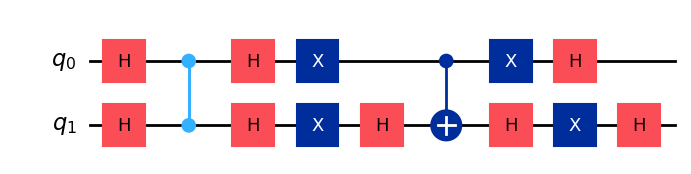

In [29]:
# Step 4: Diffusion operator (inversion about the mean) for 2 qubits
# This operator amplifies the amplitude of the marked state by reflecting
# the statevector about the average amplitude.
# It consists of:
# - Hadamard gates to switch basis
# - X gates to flip |0⟩ ↔ |1⟩
# - A controlled phase flip (CZ) on |11⟩
# - Undoing the X and Hadamard gates to return to the original basis
#
# This sequence implements the Grover diffusion operator:
# D = H^⊗n · X^⊗n · CZ · X^⊗n · H^⊗n
#
# For more details see:
# Nielsen & Chuang, "Quantum Computation and Quantum Information" (2000),
# Chapter 6.1: Grover’s algorithm

qc.h([0, 1])        # Step 4a: Hadamard gates to move to the computational basis
qc.x([0, 1])        # Step 4b: Apply X gates to flip |0⟩ ↔ |1⟩, turning |00⟩ into |11⟩

qc.h(1)             # Step 4c: Prepare for controlled-Z: Hadamard on target qubit
qc.cx(0, 1)         # Step 4d: CNOT acts as CZ in this basis, flipping phase of |11⟩
qc.h(1)             # Step 4e: Undo Hadamard on qubit 1 to complete the CZ operation

qc.x([0, 1])        # Step 4f: Undo the X gates (return qubits to original basis)
qc.h([0, 1])        # Step 4g: Final Hadamard gates to return to superposition basis

qc.draw('mpl')


In [30]:
# Step 5: Measure all qubits
qc.measure_all()

# Step 6: Simulate the circuit
backend = Aer.get_backend('aer_simulator')  # latest backend
job = backend.run(qc, shots=2000)
result = job.result()
counts = result.get_counts()
print(counts)

{'11': 2000}


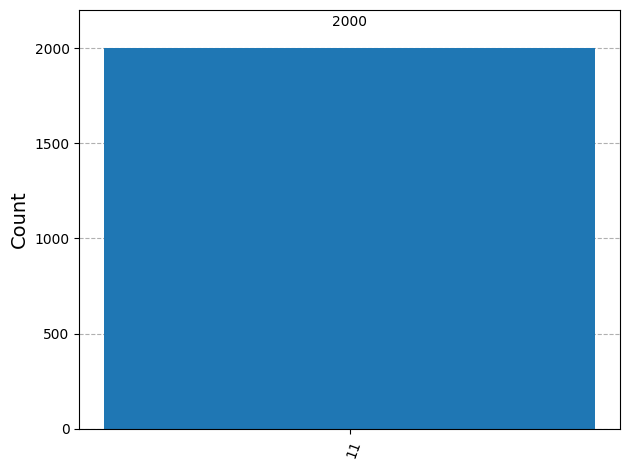

In [31]:
# Step 7: Plot results
plot_histogram(counts)